# COURSERA CAPSTONE FINAL PROJECT, WEEKS 4 & 5

## Import required libraries

In [59]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from pprint import pprint # data pretty printer

import requests # library to handle requests
from bs4 import BeautifulSoup  # library to handle web scraping

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import folium # map rendering library

import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors # Matplotlib and associated plotting modules

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from collections import Counter # count occurrences 

from sklearn.cluster import KMeans # import k-means from clustering stage

### Import and explore Toronto Neightborhoods

In [72]:
# import data frame
neighborhoods=pd.read_csv('Toronto_neighborhoods_WithGeospacial.csv')
neighborhoods.head()

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [73]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


#### Use geopy library to get the latitude and longitude values of Toronto.

In [74]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


#### Create a map of Toronto with neighborhoods superimposed on top.

In [75]:
# create map of Toronto using latitude and longitude values
map_Toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'],\
                                           neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Toronto)  
    
map_Toronto

## Define Foursquare Credentials and Version

In [88]:
# Note that these credentials are saved in Credentials.csv which is not shared on github
Cred_data=pd.read_csv('Credentials.csv')
CLIENT_ID=Cred_data['CLIENT_ID'][0]
CLIENT_SECRET=Cred_data['CLIENT_SECRET'][0]
VERSION=Cred_data['VERSION'][0]
LIMIT=Cred_data['LIMIT'][0]

**Fetch Foursquare Venue Category Hierarchy**

In [93]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
category_results = requests.get(url).json()
#category_results['response']['categories'][0]

In [94]:
for key, value in category_results['response']['categories'][0].items():
    print(key, len(str(value)))

id 24
name 20
pluralName 20
shortName 20
icon 98
categories 15910


In [96]:
category_list = category_results['response']['categories']
len(category_list)

10

In [97]:
for data in category_list:
    print(data['id'], data['name'])

4d4b7104d754a06370d81259 Arts & Entertainment
4d4b7105d754a06372d81259 College & University
4d4b7105d754a06373d81259 Event
4d4b7105d754a06374d81259 Food
4d4b7105d754a06376d81259 Nightlife Spot
4d4b7105d754a06377d81259 Outdoors & Recreation
4d4b7105d754a06375d81259 Professional & Other Places
4e67e38e036454776db1fb3a Residence
4d4b7105d754a06378d81259 Shop & Service
4d4b7105d754a06379d81259 Travel & Transport


**_Food_ & It's Sub-Categories**

Let's create a function to return a dictionary with Ids' & Names of _Food_ & It's Sub-Categories.

In [98]:
# function to flatten a 'parent_id' category, returns all categories if checkParentID = False
def flatten_Hierarchy(category_list, checkParentID, category_dict, parent_id = ''):
    for data in category_list:
        
        if checkParentID == True and data['id'] == parent_id:
            category_dict[data['id']] = data['name']
            flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
        
        elif checkParentID == False:
            category_dict[data['id']] = data['name']
            if len(data['categories']) != 0:
                flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
    
    return category_dict

In [99]:
# this function takes the parent ID and returns 'name' and 'id' of all the sub-categories
category_dict = flatten_Hierarchy(category_list, checkParentID=True, category_dict = {}, parent_id = '4d4b7105d754a06374d81259')

Now, we have all the categories in _Food_ with their id's.

#### Explore the first neighborhood to understand the results of GET Request

Get the neighborhood's name.

In [104]:
neighborhoods.loc[0, 'Neighborhood']

'Parkwoods'

Get the neighborhood's latitude and longitude values.

In [105]:
neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Parkwoods are 43.7532586, -79.3296565.


#### Now, let's get the _Food_ that is in Wakefield within a radius of 500 meters.

First, let's create the GET request URL to search for Venue with requested _Category ID_

In [106]:
LIMIT = 1 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
categoryId = '4d4b7105d754a06374d81259' # category ID for "Food"

# create URL

url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    categoryId,
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/search?&client_id=0U33ZOD3LSQU3KWWOCISFB3POET3KLFBY1JHEBCPRO2JLQVA&client_secret=FLVNBXCUK3YAD4LHYIW4JEWRRW3OE2AHUBHGVJODO0ZPXU2F&v=20180604&ll=43.7532586,-79.3296565&radius=500&categoryId=4d4b7105d754a06374d81259&limit=1'

Send the GET request and examine the resutls

In [107]:
results = requests.get(url).json()

In [108]:
results['response']['venues']

[{'id': '4e6696b6d16433b9ffff47c3',
  'name': 'KFC',
  'location': {'lat': 43.75438666345904,
   'lng': -79.3330206627504,
   'labeledLatLngs': [{'label': 'display',
     'lat': 43.75438666345904,
     'lng': -79.3330206627504}],
   'distance': 298,
   'cc': 'CA',
   'country': 'Canada',
   'formattedAddress': ['Canada']},
  'categories': [{'id': '4bf58dd8d48988d16e941735',
    'name': 'Fast Food Restaurant',
    'pluralName': 'Fast Food Restaurants',
    'shortName': 'Fast Food',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/fastfood_',
     'suffix': '.png'},
    'primary': True}],
  'referralId': 'v-1589259372',
  'hasPerk': False}]

The category name of the venue **'KFC'** is **'Food'**.

As, our aim is to segment the neighborhoods of Toronto with respect to the _Food_ in its vicinity. We need to proceed further to fetch this data from all the 103 neighborhoods' venues.

#### Let's create a function to repeat the following process to all the neighborhoods in Toronto:
* Loop through neighborhoods
    * Create the API request URL with radius=500, LIMIT=100
    * Make the GET request
    * For each neighborhood, return only relevant information for each nearby venue
    * Append all nearby venues to a list
* Unfold the list & append it to dataframe being returned

The _categoryId_ parameter in the API request URL can be a comma seperated string. So, lets create a comma seperated string from _category_\__dict_.

In [109]:
categoryId_list = []
for key, value in category_dict.items():
    categoryId_list.append(key)
categoryId = ','.join(categoryId_list)

The above process turns out to be redundant because if a top-level category is specified in the GET Request, all sub-categories will also match the query. But it is an interesting way to retrieve all the sub-categories ID with name.

In [114]:
def getNearbyFood(names, latitudes, longitudes, radius=1000, LIMIT=500):
    not_found = 0
    print('***Start ', end='')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            "4d4b7105d754a06374d81259", # "Food" category id
            LIMIT)
            
        try:
            # make the GET request
            results = requests.get(url).json()['response']['venues']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name']) for v in results])
        except:
            not_found += 1


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print("\nDone*** with {} venues with incompelete information.".format(not_found))
    return(nearby_venues)

**Let's use pickle library to serialize the information retrieved from GET requests. This step will counter any redundant requests to the Foursquare API.**

In [116]:
import pickle # to serialize and deserialize a Python object structure
try:
    with open('Toronto_food_venues.pkl', 'rb') as f:
        Toronto_venues = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")
except:
    Toronto_venues = getNearbyFood(names=neighborhoods['Neighborhood'],
                                        latitudes=neighborhoods['Latitude'],
                                        longitudes=neighborhoods['Longitude']
                                       )
    with open('Toronto_food_venues.pkl', 'wb') as f:
        pickle.dump(Toronto_venues, f)
    print("---Dataframe Created and Serialized---")

***Start  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Done*** with 0 venues with incompelete information.
---Dataframe Created and Serialized---


## 3. Analysis & Machine Learning

#### Let's check the size of the resulting dataframe

In [117]:
print(Toronto_venues.shape)
Toronto_venues.head()

(4263, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,Parkwoods,43.753259,-79.329656,Tim Hortons,43.760670,-79.326589,Coffee Shop
2,Parkwoods,43.753259,-79.329656,Allwyn's,43.761000,-79.325478,Caribbean Restaurant
3,Parkwoods,43.753259,-79.329656,A&W,43.760643,-79.326865,Fast Food Restaurant
4,Parkwoods,43.753259,-79.329656,Pizza Pizza,43.760231,-79.325666,Pizza Place


#### Let's find out how many unique categories can be curated from all the returned venues

In [118]:
print('There are {} uniques categories.'.format(len(Toronto_venues['Venue Category'].unique())))
Toronto_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 152 uniques categories.


Venue Category
Coffee Shop                      587
Pizza Place                      270
Café                             214
Bakery                           187
Restaurant                       186
Fast Food Restaurant             158
Chinese Restaurant               149
Italian Restaurant               144
Sandwich Place                   131
Caribbean Restaurant             100
Indian Restaurant                 91
Sushi Restaurant                  83
Japanese Restaurant               80
Grocery Store                     78
Middle Eastern Restaurant         77
Fried Chicken Joint               69
Asian Restaurant                  68
Mexican Restaurant                67
Burger Joint                      67
Thai Restaurant                   65
Dessert Shop                      57
Ice Cream Shop                    55
Bubble Tea Shop                   55
Breakfast Spot                    51
BBQ Joint                         50
Deli / Bodega                     48
Vietnamese Restaurant  

As we are interested in exploring the diversity of the neighborhood. Let's remove the generalized categories, like Coffee Shop, Cafe, etc.

In [119]:
# list all the categories
unique_categories = Toronto_venues['Venue Category'].unique().tolist()
print(', '.join(str(x) for x in unique_categories))

Caribbean Restaurant, Coffee Shop, Fast Food Restaurant, Pizza Place, Burger Joint, Sandwich Place, Fish & Chips Shop, Café, Bakery, Fried Chicken Joint, Chinese Restaurant, Grocery Store, French Restaurant, Portuguese Restaurant, Food, Event Space, Food Stand, Food Court, Thai Restaurant, American Restaurant, Indian Restaurant, Deli / Bodega, Middle Eastern Restaurant, Ice Cream Shop, Mediterranean Restaurant, German Restaurant, Asian Restaurant, Factory, Food Truck, Gourmet Shop, Sushi Restaurant, Bubble Tea Shop, Taco Place, Italian Restaurant, Creperie, Pakistani Restaurant, New American Restaurant, Gastropub, Restaurant, Pub, Brewery, Beer Bar, Japanese Restaurant, Mexican Restaurant, Seafood Restaurant, Hot Dog Joint, Peruvian Restaurant, Vietnamese Restaurant, Greek Restaurant, Dessert Shop, Diner, Bowling Alley, Tapas Restaurant, Shopping Mall, Noodle House, Tea Room, Convenience Store, Ramen Restaurant, Bar, Cupcake Shop, African Restaurant, Filipino Restaurant, Korean Restaur

In [128]:
len(unique_categories)

152

In [129]:
# manually create a list of generalized categories
general_categories = ['Dessert Shop','Food','Ice Cream Shop','Donut Shop','Bakery','Sandwich Place','Comfort Food Restaurant',
                    'Deli / Bodega','Food Truck','Bagel Shop','Burger Joint','Restaurant','Frozen Yogurt Shop','Coffee Shop',
                    'Diner','Wings Joint','Café','Juice Bar','Breakfast Spot','Grocery Store','Bar','Cupcake Shop',
                    'Pub','Fish & Chips Shop','Cafeteria','Other Nightlife','Arcade','Hot Dog Joint','Food Court',
                    'Health Food Store','Convenience Store','Food & Drink Shop','Cocktail Bar','Cheese Shop',
                    'Snack Place','Sports Bar','Lounge','Theme Restaurant','Buffet','Bubble Tea Shop','Building',
                    'Irish Pub','College Cafeteria','Tea Room','Supermarket','Hotpot Restaurant','Gastropub','Beer Garden',
                    'Fish Market','Beer Bar','Clothing Store','Music Venue','Bistro','Salad Place','Wine Bar','Gourmet Shop',
                    'Indie Movie Theater','Art Gallery','Gift Shop','Pie Shop','Fruit & Vegetable Store',
                    'Street Food Gathering','Dive Bar','Factory','Farmers Market','Mac & Cheese Joint','Creperie',
                    'Candy Store','Event Space','Skating Rink','Miscellaneous Shop','Gas Station','Organic Grocery',
                    'Pastry Shop','Club House','Flea Market','Hotel','Furniture / Home Store','Bookstore','Pet Café',
                    'Gym / Fitness Center','Flower Shop','Financial or Legal Service','Hotel Bar','Hookah Bar','Poke Place',
                    'Market','Gluten-free Restaurant','Smoothie Shop','Butcher','Food Stand','Beach Bar','Beach',
                    'Soup Place','Rock Club','Residential Building (Apartment / Condo)','Laundry Service',
                    'Government Building','Bowling Alley','Nightclub','Park','Moving Target']

In [130]:
len(general_categories)

102

In [131]:
# fetch all the required food categories
food_categories =  list(set(unique_categories) - set(general_categories))
print(', '.join(str(x) for x in food_categories))

Souvlaki Shop, Ethiopian Restaurant, Indonesian Restaurant, Cantonese Restaurant, Ukrainian Restaurant, American Restaurant, Brazilian Restaurant, Eastern European Restaurant, Latin American Restaurant, English Restaurant, Poutine Place, Gay Bar, Japanese Restaurant, Dim Sum Restaurant, Pizza Place, African Restaurant, Halal Restaurant, French Restaurant, Cajun / Creole Restaurant, South American Restaurant, Coworking Space, Corporate Cafeteria, Indian Restaurant, Colombian Restaurant, Burmese Restaurant, Syrian Restaurant, Vegetarian / Vegan Restaurant, Peruvian Restaurant, Burrito Place, Doner Restaurant, Shopping Mall, Harbor / Marina, Italian Restaurant, Jewish Restaurant, Tibetan Restaurant, Chinese Restaurant, Chaat Place, BBQ Joint, Swiss Restaurant, Yemeni Restaurant, Steakhouse, Vietnamese Restaurant, Mexican Restaurant, Falafel Restaurant, Brewery, Pakistani Restaurant, Bosnian Restaurant, Moroccan Restaurant, Peking Duck Restaurant, Middle Eastern Restaurant, Afghan Restaura

In [132]:
len(food_categories)

94

Let's remove all the generalized categories, like Coffee Shop, Cafe, etc.

In [133]:
Toronto_venues = Toronto_venues[Toronto_venues['Venue Category'].isin(food_categories)].reset_index()
Toronto_venues.head(5)

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Parkwoods,43.753259,-79.329656,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,2,Parkwoods,43.753259,-79.329656,Allwyn's,43.761000,-79.325478,Caribbean Restaurant
2,3,Parkwoods,43.753259,-79.329656,A&W,43.760643,-79.326865,Fast Food Restaurant
3,4,Parkwoods,43.753259,-79.329656,Pizza Pizza,43.760231,-79.325666,Pizza Place
4,11,Parkwoods,43.753259,-79.329656,Chick-N-Joy,43.759900,-79.326520,Fried Chicken Joint


In [135]:
print('There are {} unique FOOD categories.'.format(len(Toronto_venues['Venue Category'].unique())))

There are 94 unique FOOD categories.


#### Let's find out how many unique venues can be curated from all the returned venues

In [136]:
print('There are {} uniques venues.'.format(len(Toronto_venues['Venue'].unique())))

There are 1465 uniques venues.


### Analyze Each Neighborhood

In [138]:
# one hot encoding
Toronto_onehot = pd.get_dummies(Toronto_venues[['Venue Category']], prefix="", prefix_sep="")
Toronto_onehot.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bosnian Restaurant,Brazilian Restaurant,Brewery,Burmese Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chaat Place,Chinese Restaurant,Colombian Restaurant,Corporate Cafeteria,Coworking Space,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint,Gay Bar,German Restaurant,Greek Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hong Kong Restaurant,Hungarian Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Pakistani Restaurant,Peking Duck Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Pool Hall,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Shawarma Place,Shopping Mall,South American Restaurant,South Indian Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Xinjiang Restaurant,Yemeni Restaurant
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [140]:
Toronto_venues.shape

(2088, 8)

In [141]:
Toronto_onehot.shape

(2088, 94)

In [142]:
# add neighborhood column back to dataframe
Toronto_onehot['Neighborhood'] = Toronto_venues['Neighborhood'] 
Toronto_onehot.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bosnian Restaurant,Brazilian Restaurant,Brewery,Burmese Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chaat Place,Chinese Restaurant,Colombian Restaurant,Corporate Cafeteria,Coworking Space,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint,Gay Bar,German Restaurant,Greek Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hong Kong Restaurant,Hungarian Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Pakistani Restaurant,Peking Duck Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Pool Hall,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Shawarma Place,Shopping Mall,South American Restaurant,South Indian Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Xinjiang Restaurant,Yemeni Restaurant,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Parkwoods
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Parkwoods
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Parkwoods
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Parkwoods
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Parkwoods


In [143]:
# move neighborhood column to the first column
Neighborhood = Toronto_onehot['Neighborhood']

Toronto_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
Toronto_onehot.insert(0, 'Neighborhood', Neighborhood)

Toronto_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bosnian Restaurant,Brazilian Restaurant,Brewery,Burmese Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chaat Place,Chinese Restaurant,Colombian Restaurant,Corporate Cafeteria,Coworking Space,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint,Gay Bar,German Restaurant,Greek Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hong Kong Restaurant,Hungarian Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Pakistani Restaurant,Peking Duck Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Pool Hall,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Shawarma Place,Shopping Mall,South American Restaurant,South Indian Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Xinjiang Restaurant,Yemeni Restaurant
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [144]:
Toronto_onehot.shape

(2088, 95)

Let's count venues of each category in each neighborhood

In [147]:
venue_counts = Toronto_onehot.groupby('Neighborhood').sum()
venue_counts.head(5)

,Afghan Restaurant,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bosnian Restaurant,Brazilian Restaurant,Brewery,Burmese Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chaat Place,Chinese Restaurant,Colombian Restaurant,Corporate Cafeteria,Coworking Space,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint,Gay Bar,German Restaurant,Greek Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hong Kong Restaurant,Hungarian Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Pakistani Restaurant,Peking Duck Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Pool Hall,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Shawarma Place,Shopping Mall,South American Restaurant,South Indian Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Xinjiang Restaurant,Yemeni Restaurant
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Agincourt,0,0,0,3,0,3,0,0,0,0,0,0,1,2,0,16,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
"Alderwood, Long Branch",0,0,1,2,0,2,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,1,0,0,0
"Bathurst Manor, Wilson Heights, Downsview North",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Bayview Village,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
"Bedford Park, Lawrence Manor East",0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


Let's find out the top 10 food categories in Toronto

In [148]:
venue_counts_described = venue_counts.describe().transpose()

In [149]:
venue_top10 = venue_counts_described.sort_values('max', ascending=False)[0:10]
venue_top10

,count,mean,std,min,25%,50%,75%,max
Chinese Restaurant,97.0,1.536082,2.458242,0.0,0.0,1.0,2.0,16.0
Vietnamese Restaurant,97.0,0.474227,1.555185,0.0,0.0,0.0,0.0,14.0
Greek Restaurant,97.0,0.350515,1.331049,0.0,0.0,0.0,0.0,12.0
Pizza Place,97.0,2.783505,2.381468,0.0,1.0,2.0,4.0,11.0
Caribbean Restaurant,97.0,1.030928,1.496201,0.0,0.0,0.0,2.0,10.0
Korean Restaurant,97.0,0.350515,1.283235,0.0,0.0,0.0,0.0,9.0
Middle Eastern Restaurant,97.0,0.793814,1.145081,0.0,0.0,0.0,1.0,7.0
Fast Food Restaurant,97.0,1.628866,1.516023,0.0,0.0,1.0,3.0,7.0
Latin American Restaurant,97.0,0.268041,0.797332,0.0,0.0,0.0,0.0,6.0
Italian Restaurant,97.0,1.484536,1.702409,0.0,0.0,1.0,2.0,6.0


In [150]:
venue_top10_list = venue_top10.index.values.tolist()

In [151]:
venue_top10_list 

['Chinese Restaurant',
 'Vietnamese Restaurant',
 'Greek Restaurant',
 'Pizza Place',
 'Caribbean Restaurant',
 'Korean Restaurant',
 'Middle Eastern Restaurant',
 'Fast Food Restaurant',
 'Latin American Restaurant',
 'Italian Restaurant']

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  if sys.path[0] == '':


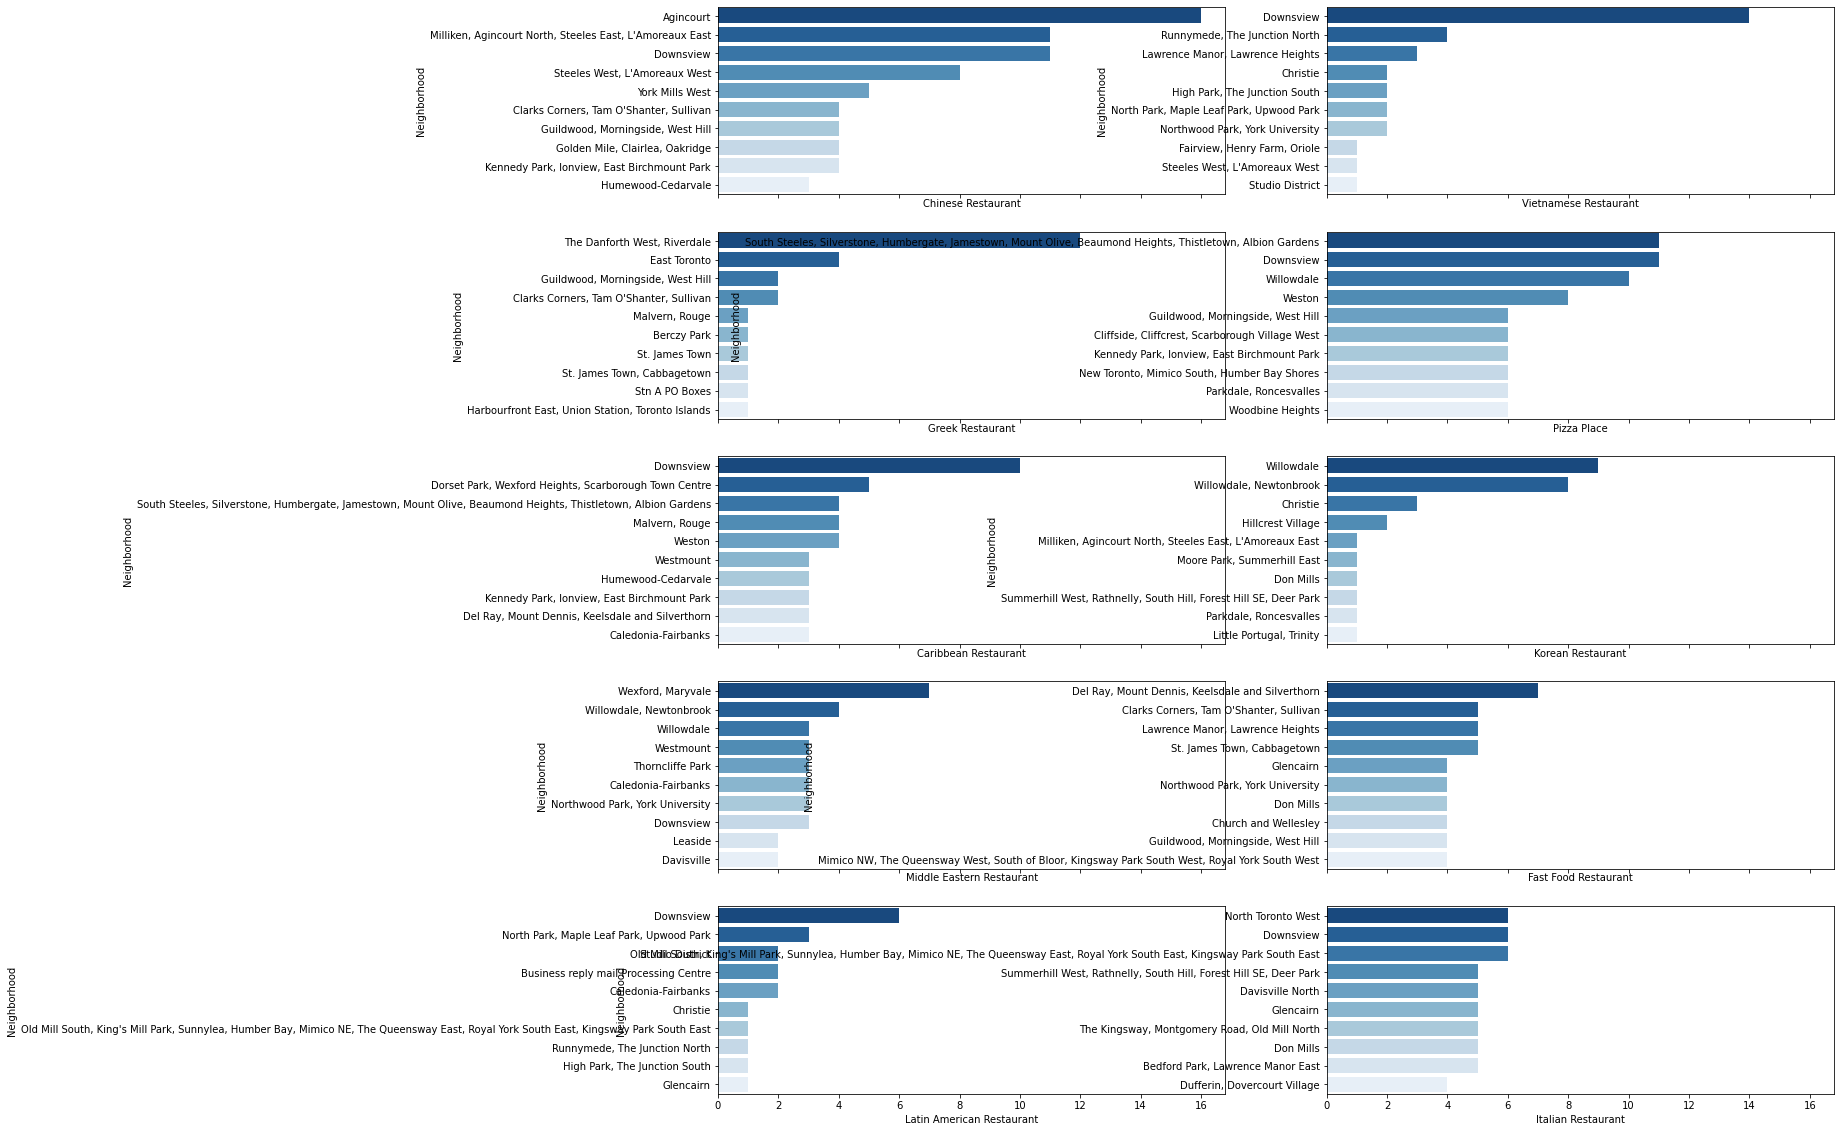

In [154]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes =plt.subplots(5, 2, figsize=(20,20), sharex=True)
axes = axes.flatten()

for ax, category in zip(axes, venue_top10_list):
    data = venue_counts[[category]].sort_values([category], ascending=False)[0:10]
    pal = sns.color_palette("Blues", len(data))
    sns.barplot(x=category, y=data.index, data=data, ax=ax, palette=np.array(pal[::-1]))

plt.tight_layout()
plt.show();

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [155]:
Toronto_grouped = Toronto_onehot.groupby('Neighborhood').mean().reset_index()
Toronto_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bosnian Restaurant,Brazilian Restaurant,Brewery,Burmese Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chaat Place,Chinese Restaurant,Colombian Restaurant,Corporate Cafeteria,Coworking Space,Dim Sum Restaurant,Doner Restaurant,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,Fried Chicken Joint,Gay Bar,German Restaurant,Greek Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Hong Kong Restaurant,Hungarian Restaurant,Indian Chinese Restaurant,Indian Restaurant,Indonesian Restaurant,Italian Restaurant,Japanese Restaurant,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,Pakistani Restaurant,Peking Duck Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Pool Hall,Portuguese Restaurant,Poutine Place,Ramen Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shanghai Restaurant,Shawarma Place,Shopping Mall,South American Restaurant,South Indian Restaurant,Souvlaki Shop,Spanish Restaurant,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Xinjiang Restaurant,Yemeni Restaurant
0,Agincourt,0.0,0.0,0.000000,0.078947,0.0,0.078947,0.0,0.0,0.0,0.000000,0.0,0.0,0.026316,0.052632,0.0,0.421053,0.0,0.0,0.0,0.026316,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.026316,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026316,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.026316,0.026316,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.026316,0.0,0.0,0.0,0.026316,0.0,0.0,0.0,0.0,0.0,0.0,0.026316,0.026316,0.0,0.0,0.0,0.0,0.0,0.0,0.026316,0.0,0.026316,0.0,0.0,0.026316,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.026316,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.047619,0.095238,0.0,0.095238,0.0,0.0,0.0,0.047619,0.0,0.0,0.000000,0.000000,0.0,0.047619,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.047619,0.0,0.047619,0.0,0.142857,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.047619,0.047619,0.0,0.000000,0.0,0.0,0.0,0.095238,0.0,0.0,0.0,0.0,0.0,0.0,0.047619,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.095238,0.0,0.047619,0.0,0.0,0.047619,0.000000,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.083333,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.083333,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.000000,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.083333,0.000000,0.0,0.083333,0.0,0.000000,0.000000,0.083333,0.0,0.166667,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.083333,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
3,Bayview Village,0.0,0.0,0.000000,0.222222,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.111111,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.222222,0.000000,0.0,0.111111,0.0,0.000000,0.000000,0.000000,0.0,0.111111,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000

#### Let's confirm the new size

In [156]:
Toronto_grouped.shape

(97, 95)

#### Let's write a function to sort the venues in descending order.

In [157]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 5 venues for each neighborhood.

In [158]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))    

In [160]:
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Toronto_grouped['Neighborhood']

In [161]:
for ind in np.arange(Toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Agincourt,Chinese Restaurant,Asian Restaurant,BBQ Joint,Caribbean Restaurant,Dim Sum Restaurant
1,"Alderwood, Long Branch",Italian Restaurant,BBQ Joint,Asian Restaurant,Pizza Place,Thai Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Middle Eastern Restaurant,Pizza Place,Korean Restaurant,Sushi Restaurant,Mediterranean Restaurant
3,Bayview Village,Japanese Restaurant,Asian Restaurant,Sushi Restaurant,Korean Restaurant,Middle Eastern Restaurant
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Sushi Restaurant,Chinese Restaurant,Indian Restaurant,Pizza Place


### Cluster Neighborhoods

Run *k*-means to count Neighborhoods for each cluster label for variable cluster size

In [162]:
Toronto_grouped_clustering = Toronto_grouped.drop('Neighborhood', 1)

#### Determine the optimal number of clusters for k-means clustering

**The Elbow Method** - calculate the sum of squared distances of samples to their closest cluster center for different values of k. The value of k after which there is no siginificant decrease in sum of squared distances is choosen.

In [165]:
sum_of_squared_distances = []
K = range(1,50)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(Toronto_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

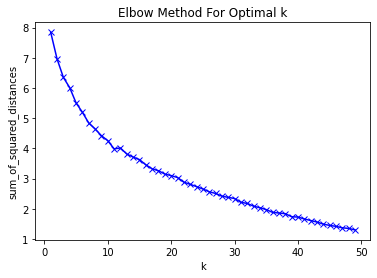

In [166]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k');

Elbow method does not seem to help us to determine the optimal number of clusters. Let's use another method.

**The Silhouette Method** - The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation). Source: Wikipedia

In [169]:
from sklearn.metrics import silhouette_score

sil = []
K_sil = range(2,50)
# minimum 2 clusters required, to define dissimilarity
for k in K_sil:
    print(k, end=' ')
    kmeans = KMeans(n_clusters = k).fit(Toronto_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(Toronto_grouped_clustering, labels, metric = 'euclidean'))

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

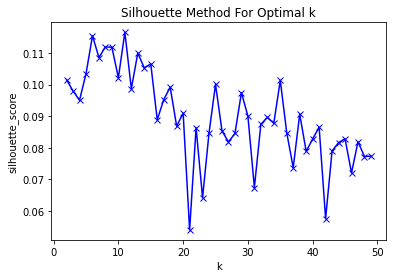

In [170]:
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()

In [175]:
pd.DataFrame({'Sil':sil,'ksil':K_sil}).head(15)

,Sil,ksil
0,0.101538,2
1,0.097988,3
2,0.095067,4
3,0.103427,5
4,0.115439,6
5,0.108573,7
6,0.111956,8
7,0.111824,9
8,0.102211,10
9,0.116582,11


There is a peak at k = 6.
#### Let's set number of clusters = 6

In [176]:
# set number of clusters
kclusters = 6

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=50).fit(Toronto_grouped_clustering)

print(Counter(kmeans.labels_))

Counter({2: 32, 5: 24, 1: 23, 4: 12, 0: 5, 3: 1})


Let's create a new dataframe that includes the cluster as well as the top 5 venues for each neighborhood.

In [177]:
# add clustering labels
try:
    neighborhoods_venues_sorted.drop('Cluster Labels', axis=1)
except:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [178]:
neighborhoods_venues_sorted.head(5)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,0,Agincourt,Chinese Restaurant,Asian Restaurant,BBQ Joint,Caribbean Restaurant,Dim Sum Restaurant
1,1,"Alderwood, Long Branch",Italian Restaurant,BBQ Joint,Asian Restaurant,Pizza Place,Thai Restaurant
2,2,"Bathurst Manor, Wilson Heights, Downsview North",Middle Eastern Restaurant,Pizza Place,Korean Restaurant,Sushi Restaurant,Mediterranean Restaurant
3,4,Bayview Village,Japanese Restaurant,Asian Restaurant,Sushi Restaurant,Korean Restaurant,Middle Eastern Restaurant
4,1,"Bedford Park, Lawrence Manor East",Italian Restaurant,Sushi Restaurant,Chinese Restaurant,Indian Restaurant,Pizza Place


In [179]:
# merge neighborhoods_venues_sorted with Toronto_data to add latitude/longitude for each neighborhood
Toronto_merged = neighborhoods_venues_sorted.join(neighborhoods.set_index('Neighborhood'), on='Neighborhood')
Toronto_merged.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Postalcode,Borough,Latitude,Longitude
0,0,Agincourt,Chinese Restaurant,Asian Restaurant,BBQ Joint,Caribbean Restaurant,Dim Sum Restaurant,M1S,Scarborough,43.794200,-79.262029
1,1,"Alderwood, Long Branch",Italian Restaurant,BBQ Joint,Asian Restaurant,Pizza Place,Thai Restaurant,M8W,Etobicoke,43.602414,-79.543484
2,2,"Bathurst Manor, Wilson Heights, Downsview North",Middle Eastern Restaurant,Pizza Place,Korean Restaurant,Sushi Restaurant,Mediterranean Restaurant,M3H,North York,43.754328,-79.442259
3,4,Bayview Village,Japanese Restaurant,Asian Restaurant,Sushi Restaurant,Korean Restaurant,Middle Eastern Restaurant,M2K,North York,43.786947,-79.385975
4,1,"Bedford Park, Lawrence Manor East",Italian Restaurant,Sushi Restaurant,Chinese Restaurant,Indian Restaurant,Pizza Place,M5M,North York,43.733283,-79.419750


Finally, let's visualize the resulting clusters

In [180]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged['Latitude'], Toronto_merged['Longitude'], Toronto_merged['Neighborhood'], Toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Results

In [182]:
required_column_indices = [2,3,7]
required_column = [list(Toronto_merged.columns.values)[i] for i in required_column_indices]
required_column_indices = [2,3,7]

#### Cluster 0

In [184]:
cluster_0 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 0, Toronto_merged.columns[1:12]]
cluster_0.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Postalcode,Borough,Latitude,Longitude
0,Agincourt,Chinese Restaurant,Asian Restaurant,BBQ Joint,Caribbean Restaurant,Dim Sum Restaurant,M1S,Scarborough,43.794200,-79.262029
33,"Golden Mile, Clairlea, Oakridge",Chinese Restaurant,Indian Restaurant,Pizza Place,Falafel Restaurant,Vegetarian / Vegan Restaurant,M1L,Scarborough,43.711112,-79.284577
51,"Milliken, Agincourt North, Steeles East, L'Amo...",Chinese Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Noodle House,Fast Food Restaurant,M1V,Scarborough,43.815252,-79.284577
75,"Steeles West, L'Amoreaux West",Chinese Restaurant,Indian Restaurant,Fast Food Restaurant,Caribbean Restaurant,Middle Eastern Restaurant,M1W,Scarborough,43.799525,-79.318389
95,York Mills West,Chinese Restaurant,Noodle House,Pizza Place,Korean Restaurant,Caribbean Restaurant,M2P,North York,43.752758,-79.400049


In [185]:
for col in required_column:
    print(cluster_0[col].value_counts(ascending = False))
    print("---------------------------------------------")

Chinese Restaurant    5
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Indian Restaurant    2
Asian Restaurant     2
Noodle House         1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
M2P    1
M1L    1
M1W    1
M1V    1
M1S    1
Name: Postalcode, dtype: int64
---------------------------------------------


#### Cluster 1

In [186]:
cluster_1 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 1, Toronto_merged.columns[1:12]]
cluster_1.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Postalcode,Borough,Latitude,Longitude
1,"Alderwood, Long Branch",Italian Restaurant,BBQ Joint,Asian Restaurant,Pizza Place,Thai Restaurant,M8W,Etobicoke,43.602414,-79.543484
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Sushi Restaurant,Chinese Restaurant,Indian Restaurant,Pizza Place,M5M,North York,43.733283,-79.419750
5,Berczy Park,Italian Restaurant,Chinese Restaurant,Latin American Restaurant,Greek Restaurant,Fried Chicken Joint,M5E,Downtown Toronto,43.644771,-79.373306
14,Christie,Pizza Place,Italian Restaurant,Japanese Restaurant,Korean Restaurant,Vietnamese Restaurant,M6G,Downtown Toronto,43.669542,-79.422564
19,Davisville,Japanese Restaurant,Italian Restaurant,Thai Restaurant,Pizza Place,French Restaurant,M4S,Central Toronto,43.704324,-79.388790


In [187]:
for col in required_column:
    print(cluster_1[col].value_counts(ascending = False))
    print("---------------------------------------------")

Italian Restaurant      12
Pizza Place              6
Japanese Restaurant      2
Filipino Restaurant      1
African Restaurant       1
Fast Food Restaurant     1
Sushi Restaurant         1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Italian Restaurant             9
Pizza Place                    4
Sushi Restaurant               3
Fast Food Restaurant           1
African Restaurant             1
BBQ Joint                      1
Japanese Restaurant            1
Mexican Restaurant             1
Chinese Restaurant             1
Eastern European Restaurant    1
American Restaurant            1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
M8W    1
M4W    1
M8Y    1
M6H    1
M9L    1
M6B    1
M4V    1
M4T    1
M5N    1
M3C    1
M8X    1
M6G    1
M4N    1
M5P    1
M5M    1
M4P    1
M4R    1
M5E    1
M9M    1
M3B    1
M1C    1
M4S    1
M4M    1
M6S    1
Name: Postalcode, dtype: int64
-------------------------

#### Cluster 2

In [188]:
cluster_2 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 2, Toronto_merged.columns[1:12]]
cluster_2.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Postalcode,Borough,Latitude,Longitude
2,"Bathurst Manor, Wilson Heights, Downsview North",Middle Eastern Restaurant,Pizza Place,Korean Restaurant,Sushi Restaurant,Mediterranean Restaurant,M3H,North York,43.754328,-79.442259
6,"Birch Cliff, Cliffside West",Indian Restaurant,Asian Restaurant,Thai Restaurant,Pizza Place,Japanese Restaurant,M1N,Scarborough,43.692657,-79.264848
7,"Brockton, Parkdale Village, Exhibition Place",Indian Restaurant,Tibetan Restaurant,Pizza Place,Chinese Restaurant,Poutine Place,M6K,West Toronto,43.636847,-79.428191
8,Business reply mail Processing Centre,Pizza Place,Indian Restaurant,Fast Food Restaurant,BBQ Joint,Italian Restaurant,M7Y,East Toronto,43.662744,-79.321558
9,"CN Tower, King and Spadina, Railway Lands, Har...",Chinese Restaurant,BBQ Joint,American Restaurant,Sushi Restaurant,Burrito Place,M5V,Downtown Toronto,43.628947,-79.394420


In [189]:
for col in required_column:
    print(cluster_2[col].value_counts(ascending = False))
    print("---------------------------------------------")

Fast Food Restaurant         7
Indian Restaurant            6
Vietnamese Restaurant        4
Caribbean Restaurant         3
Pizza Place                  3
Middle Eastern Restaurant    2
Greek Restaurant             2
Asian Restaurant             2
Ramen Restaurant             1
Latin American Restaurant    1
African Restaurant           1
Korean Restaurant            1
Chinese Restaurant           1
Sushi Restaurant             1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Pizza Place                  9
Fast Food Restaurant         3
Asian Restaurant             2
Caribbean Restaurant         2
Sushi Restaurant             2
Chinese Restaurant           2
Vietnamese Restaurant        2
Indian Restaurant            2
BBQ Joint                    1
Tibetan Restaurant           1
African Restaurant           1
Ramen Restaurant             1
Thai Restaurant              1
Filipino Restaurant          1
Italian Restaurant           1
Mexican Resta

#### Cluster 3

In [190]:
cluster_3 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 3, Toronto_merged.columns[1:12]]
cluster_3.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Postalcode,Borough,Latitude,Longitude
96,"York Mills, Silver Hills",Middle Eastern Restaurant,Mediterranean Restaurant,Yemeni Restaurant,Halal Restaurant,Falafel Restaurant,M2L,North York,43.75749,-79.374714


In [191]:
for col in required_column:
    print(cluster_3[col].value_counts(ascending = False))
    print("---------------------------------------------")

Middle Eastern Restaurant    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Mediterranean Restaurant    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
M2L    1
Name: Postalcode, dtype: int64
---------------------------------------------


#### Cluster 4

In [192]:
cluster_4 = Toronto_merged.loc[Toronto_merged['Cluster Labels'] == 4, Toronto_merged.columns[1:12]]
cluster_4.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Postalcode,Borough,Latitude,Longitude
3,Bayview Village,Japanese Restaurant,Asian Restaurant,Sushi Restaurant,Korean Restaurant,Middle Eastern Restaurant,M2K,North York,43.786947,-79.385975
13,Central Bay Street,Mexican Restaurant,Fried Chicken Joint,Italian Restaurant,Sushi Restaurant,Japanese Restaurant,M5G,Downtown Toronto,43.657952,-79.387383
15,Church and Wellesley,Italian Restaurant,Fast Food Restaurant,Fried Chicken Joint,Japanese Restaurant,Mexican Restaurant,M4Y,Downtown Toronto,43.665860,-79.383160
18,"Commerce Court, Victoria Hotel",Japanese Restaurant,Mexican Restaurant,Fried Chicken Joint,French Restaurant,Sushi Restaurant,M5L,Downtown Toronto,43.648198,-79.379817
29,"First Canadian Place, Underground city",Japanese Restaurant,Mexican Restaurant,Fried Chicken Joint,Italian Restaurant,Vegetarian / Vegan Restaurant,M5X,Downtown Toronto,43.648429,-79.382280


In [193]:
for col in required_column:
    print(cluster_4[col].value_counts(ascending = False))
    print("---------------------------------------------")

Japanese Restaurant    6
Italian Restaurant     5
Mexican Restaurant     1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Fried Chicken Joint     3
Mexican Restaurant      3
Fast Food Restaurant    2
Ramen Restaurant        1
Italian Restaurant      1
Sushi Restaurant        1
Asian Restaurant        1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
M5C    1
M7A    1
M5W    1
M5X    1
M5B    1
M5K    1
M2K    1
M5T    1
M5L    1
M4Y    1
M5G    1
M5H    1
Name: Postalcode, dtype: int64
---------------------------------------------
